# Assignment 2: Depth Estimation.
Depth estimation is a computer vision task that involves calculating the distance of each pixel in an image relative to the camera. This information is crucial in a variety of applications, such as autonomous driving, robotics, and virtual reality. There are two main methods for estimating depth: monocular and stereo. Monocular depth estimation involves using a single image to calculate depth. This can be achieved through various techniques, such as using machine learning algorithms to predict depth from a single image, or by using known object sizes to estimate the distance of objects in the scene. Stereo depth estimation, on the other hand, involves using multiple views of a scene to calculate depth. This is achieved by comparing the differences in pixel locations between two or more images taken from slightly different viewpoints. The closer an object is to the camera, the greater the difference in pixel location between the two images. 


In this assignment, you will explore both stereo and monocular (DL based) depth estimation techniques on the KITTI dataset https://www.cvlibs.net/datasets/kitti/. The KITTI dataset is widely used for mobile robotics and autonomous driving. It includes tasks related to stereo, optical flow, visual odometry, 3D object detection, and 3D tracking. The dataset comprises two high-resolution cameras, one for color and one for grayscale, and provides accurate ground truth through a Velodyne laser scanner and a GPS localization system.

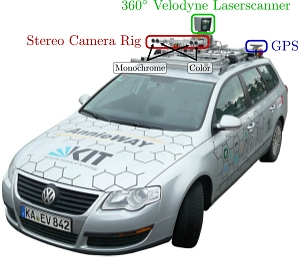

The monocular DL approach consists of using two models - manydepth and monodepth (both trained on kitti). Monodepth takes in a single frame to predict depth, whereas manydepth uses 2 frames to generate a lower error depth map.

# Download & Install Datasets and Libraries

In [1]:
#!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
    
#!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
    
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt 

!git clone https://github.com/nianticlabs/monodepth2.git
    
!git clone https://github.com/nianticlabs/manydepth.git
#!wget https://storage.googleapis.com/niantic-lon-static/research/manydepth/models/KITTI_MR.zip

!pip install git+https://github.com/AdityaNG/manydepth@pip-module
import manydepth

from manydepth import networks
from manydepth.layers import transformation_from_parameters

fatal: destination path 'yolov5' already exists and is not an empty directory.
ERROR: Could not find a version that satisfies the requirement gitpython>=3.1.30 (from versions: 0.1.7, 0.2.0b1, 0.3.0b1, 0.3.0b2, 0.3.1b2, 0.3.2rc1, 0.3.2, 0.3.2.1, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.3.7, 1.0.0, 1.0.1, 1.0.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9.dev0, 2.0.9.dev1, 2.0.9, 2.1.0, 2.1.1, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.1.7, 2.1.8, 2.1.9, 2.1.10, 2.1.11, 2.1.12, 2.1.13, 2.1.14, 2.1.15, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.0.4, 3.0.5, 3.0.6, 3.0.7, 3.0.8, 3.0.9, 3.1.0, 3.1.1, 3.1.2, 3.1.3, 3.1.4, 3.1.5, 3.1.6, 3.1.7, 3.1.8, 3.1.9, 3.1.10, 3.1.11, 3.1.12, 3.1.13, 3.1.14, 3.1.15, 3.1.16, 3.1.17, 3.1.18, 3.1.19, 3.1.20)
ERROR: No matching distribution found for gitpython>=3.1.30
fatal: destination path 'monodepth2' already exists and is not an empty directory.
fatal: destination path 'manydepth' already exists and is not an empty directory.


  Cloning https://github.com/AdityaNG/manydepth (to revision pip-module) to c:\users\connor\appdata\local\temp\pip-req-build-9380l311
  Resolved https://github.com/AdityaNG/manydepth to commit 0650e5bf1a9b53ad911f171edd444b6b16af2038


  Running command git clone -q https://github.com/AdityaNG/manydepth 'C:\Users\Connor\AppData\Local\Temp\pip-req-build-9380l311'
  Running command git checkout -b pip-module --track origin/pip-module
  branch 'pip-module' set up to track 'origin/pip-module'.
  Switched to a new branch 'pip-module'


In [1]:
import zipfile
import os
import sys
from glob import glob

import cv2
import numpy as np
import pandas as pd

import torch
from torchvision import transforms

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import PIL.Image as pil

# MONODEPTH
sys.path.append("/kaggle/working/monodepth2")
from monodepth2.layers import ConvBlock
from monodepth2.layers import Conv3x3, disp_to_depth
from monodepth2.utils import download_model_if_doesnt_exist
from monodepth2.networks.depth_decoder import DepthDecoder
from monodepth2.networks.resnet_encoder import ResnetEncoder

# MANYDEPTH
sys.path.append("/kaggle/working/manydepth")
from manydepth.networks.resnet_encoder import ResnetEncoderMatching
from manydepth.networks.resnet_encoder import ResnetEncoder as manydepthResnetEncoder
from manydepth.networks.pose_decoder import PoseDecoder as manydepthPoseDecoder
from manydepth.networks.depth_decoder import DepthDecoder as manydepthDepthDecoder
from manydepth.layers import transformation_from_parameters

ModuleNotFoundError: No module named 'layers'

# Extract Paths and Useful Parameters

In [ ]:
with zipfile.ZipFile('/kaggle/working/2011_09_26_drive_0106_sync.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data')
    
data_path = '/kaggle/working/data/2011_09_26/2011_09_26_drive_0106_sync'

with zipfile.ZipFile('/kaggle/working/2011_09_26_calib.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/calib')
    
calib_path = '/kaggle/working/calib/2011_09_26/2011_09_26_drive_0106_sync'

    
with zipfile.ZipFile('/kaggle/working/KITTI_MR.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/manydepth_model_kitti_mr')

left_image_paths = sorted(glob(os.path.join(data_path, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(data_path, 'image_03/data/*.png')))
bin_paths = sorted(glob(os.path.join(data_path, 'velodyne_points/data/*.bin')))

with open('/kaggle/working/calib/2011_09_26/calib_cam_to_cam.txt','r') as f:
    cam_calib = f.readlines()
    
with open(r'/kaggle/working/calib/2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    velo_calib = f.readlines()

P_left = np.array([float(x) for x in cam_calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in cam_calib[33].strip().split(' ')[1:]]).reshape((3,4))

R_left_rect = np.array([float(x) for x in cam_calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)

R_right_rect = np.array([float(x) for x in cam_calib[32].strip().split(' ')[1:]]).reshape((3, 3,))
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

R_cam_velo = np.array([float(x) for x in velo_calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in velo_calib[2].strip().split(' ')[1:]])[:, None]
T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),np.array([0, 0, 0, 1])))

# Helper Functions

In [ ]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [ ]:
def get_velo2cam(lidar_bin):
    ''' Converts the LiDAR point cloud to camera (u, v, z) image coordinates, 
        where z is in meters
        '''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # convert to homogeneous coordinate system
    velo_points = scan_data[:, 0:3] # (x, y, z) --> (front, left, up)
    velo_points = np.insert(velo_points, 3, 1, axis=1).T # homogeneous LiDAR points

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1) 

    # possibly use RANSAC to remove the ground plane for better viewing?

    # convert to camera coordinates
    velo_camera = P_left @ R_left_rect @ T_cam_velo @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    return velo_camera

In [ ]:
def project_velo2cam(lidar_bin, image):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)
    
    return velo_camera

In [ ]:
def load_and_preprocess_image(image_path, resize_width, resize_height):
    image = pil.open(image_path).convert('RGB')
    original_width, original_height = image.size
    image = image.resize((resize_width, resize_height), pil.LANCZOS)
    image = transforms.ToTensor()(image).unsqueeze(0)
    if torch.cuda.is_available():
        return image.cuda(), (original_height, original_width)
    return image, (original_height, original_width)

In [ ]:
def load_and_preprocess_intrinsics(K_inp, resize_width, resize_height):
    K = np.eye(4)
    K[:3, :3] = K_inp

    # Convert normalised intrinsics to 1/4 size unnormalised intrinsics.
    # (The cost volume construction expects the intrinsics corresponding to 1/4 size images)
    K[0, :] *= resize_width // 4
    K[1, :] *= resize_height // 4

    invK = torch.Tensor(np.linalg.pinv(K)).unsqueeze(0)
    K = torch.Tensor(K).unsqueeze(0)

    if torch.cuda.is_available():
        return K.cuda(), invK.cuda()
    else:
        return K, invK

# 1. View Left and Right Images & Comment on Disparity.

In [ ]:
img_index = 80

left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[img_index]), cv2.COLOR_BGR2RGB)

pt_1 = (200, 325)
pt_2 = (600, 150)

cv2.circle(left_image, pt_1, 10, [255, 0, 0], -1)
cv2.circle(right_image, pt_1, 10, [255, 0, 0], -1)
cv2.circle(left_image, pt_2, 10, [0, 255, 0], -1)
cv2.circle(right_image, pt_2, 10, [0, 255, 0], -1)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

# Notice how the Red pt has a greater 'shift' than the green point.
# Comment on why this is and how it might effect depth estimation?
# Answer:

# 2. Generate Disparity Map thru' classical and DL approaches.

# 2a. Stereo Disparity Map.

In [ ]:
# TODO For Students.
def compute_sgbm_disparity(left_image, right_image, num_disparities, block_size, window_size):
    # Use cv2.StereoSGBM_create to generate a sgbm object and compute the disparity on it for the L and R images.
    # Inputs:
        # 1. image_left/_right - (MxN) grayscale input images
        # 2. num_disparities 
        # 3. block_size
        # 4. window_size
    # Outputs:
        # 1. disparity - (MxN) computed disparity map for the input images
        
    return disparity

# Use the function defined above and vary the 3 input parameters (num_disparities, block_size, window_size).

In [ ]:
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

# Use the below values as initial guesses. Try 3 other combinations.
num_disparities = 96
block_size = 5
window_size = 5
disparity_stereo = compute_sgbm_disparity(left_image_gray, right_image_gray, num_disparities, block_size, window_size)

plt.figure(figsize = (40,20))
plt.imshow(disparity_stereo, cmap='cividis')
plt.title('Disparity Map', size=25)
plt.show();

# What effect does num_disparities, block_size, and window_size have on the disparity map. How can you go about fixing the 'noise' in the image?
# Answer:

# 2b. Monodepth. Mono Trained.

In [ ]:
model_name = "mono_640x192"
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)
encoder.eval()
depth_decoder.eval();

In [ ]:
image_path = left_image_paths[img_index]
resize_height = loaded_dict_enc['height']
resize_width = loaded_dict_enc['width']
image, original_size = load_and_preprocess_image(image_path, resize_width, resize_height)

with torch.no_grad():
    features = encoder(image)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp, original_size, mode="bilinear", align_corners=False)
disp_resized_np = disp_resized.squeeze().cpu().numpy()
disparity_map_monodepth_1 = disp_resized_np
plt.imshow(disparity_map_monodepth_1, cmap='cividis')

# 2c. Monodepth. Mono+Stereo Trained.

In [ ]:
model_name = "mono+stereo_640x192"
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)
encoder.eval()
depth_decoder.eval();

In [ ]:
image_path = left_image_paths[img_index]
resize_height = loaded_dict_enc['height']
resize_width = loaded_dict_enc['width']
image, original_size = load_and_preprocess_image(image_path, resize_width, resize_height)

with torch.no_grad():
    features = encoder(image)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp, original_size, mode="bilinear", align_corners=False)
disp_resized_np = disp_resized.squeeze().cpu().numpy()
disparity_map_monodepth_2 = disp_resized_np
plt.imshow(disparity_map_monodepth_2, cmap='cividis')

# 2d. Manydepth

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path_model = '/kaggle/working/manydepth_model_kitti_mr/KITTI_MR'
encoder_dict = torch.load(os.path.join(path_model, "encoder.pth"), map_location=device)

In [ ]:
encoder = ResnetEncoderMatching(18, False,
                                    input_width=encoder_dict['width'],
                                    input_height=encoder_dict['height'],
                                    adaptive_bins=True,
                                    min_depth_bin=encoder_dict['min_depth_bin'],
                                    max_depth_bin=encoder_dict['max_depth_bin'],
                                    depth_binning='linear',
                                    num_depth_bins=96)
filtered_dict_enc = {k: v for k, v in encoder_dict.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

print("Loading pretrained decoder")
depth_decoder = manydepthDepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

print("Loading pose network")
pose_enc_dict = torch.load(os.path.join(path_model, "pose_encoder.pth"), map_location=device)
pose_dec_dict = torch.load(os.path.join(path_model, "pose.pth"), map_location=device)
pose_enc = manydepthResnetEncoder(18, False, num_input_images=2)
pose_dec = manydepthPoseDecoder(pose_enc.num_ch_enc, num_input_features=1,num_frames_to_predict_for=2)
pose_enc.load_state_dict(pose_enc_dict, strict=True)
pose_dec.load_state_dict(pose_dec_dict, strict=True)

# Setting states of networks
encoder.eval()
depth_decoder.eval()
pose_enc.eval()
pose_dec.eval()
if torch.cuda.is_available():
    encoder.cuda()
    depth_decoder.cuda()
    pose_enc.cuda()
    pose_dec.cuda()

In [ ]:
input_image, original_size = load_and_preprocess_image(left_image_paths[img_index],resize_width=encoder_dict['width'],resize_height=encoder_dict['height'])
source_image, _ = load_and_preprocess_image(left_image_paths[img_index-1], resize_width=encoder_dict['width'], resize_height=encoder_dict['height'])

K_left, R_left, T_left = decompose_projection_matrix(P_left)

resize_width=encoder_dict['width']
resize_height=encoder_dict['height']
K, invK = load_and_preprocess_intrinsics(K_left,resize_width,resize_height)

In [ ]:
with torch.no_grad():
    pose_inputs = [source_image, input_image]
    pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
    axisangle, translation = pose_dec(pose_inputs)
    pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)
    
    output, lowest_cost, _ = encoder(current_image=input_image,
                                        lookup_images=source_image.unsqueeze(1),
                                        poses=pose.unsqueeze(1),
                                        K=K,
                                        invK=invK,
                                        min_depth_bin=encoder_dict['min_depth_bin'],
                                        max_depth_bin=encoder_dict['max_depth_bin'])
    
    output = depth_decoder(output)
    sigmoid_output = output[("disp", 0)]
    sigmoid_output_resized = torch.nn.functional.interpolate(sigmoid_output, original_size, mode="bilinear", align_corners=False)
    sigmoid_output_resized = sigmoid_output_resized.cpu().numpy()[:, 0]
    disparity_map_manydepth = np.reshape(sigmoid_output_resized, (375, 1242))
    plt.imshow(disparity_map_manydepth, cmap='cividis')

# You have outputted a disparity map for the above 3 methods. Compare each and comment on the disparity map.

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))

ax1.imshow(disparity_stereo, cmap='cividis')
ax1.set_title('Stereo_Disparity', size=22)

ax2.imshow(disparity_map_monodepth_1, cmap='cividis')
ax2.set_title('Monodepth_mono_disparity', size=22)

ax3.imshow(disparity_map_monodepth_2, cmap='cividis')
ax3.set_title('Monodepth_mono+stereo_disparity', size=22)

ax4.imshow(disparity_map_manydepth, cmap='cividis')
ax4.set_title('Manydepth_disparity', size=22)

plt.tight_layout()  # Adjust layout to prevent overlap if necessary
plt.show()

# Student's Answer: 

# 3. Generate Depth Map


# 3a. Stereo Pair Depth Map

In [ ]:
# TODO For Students
def calc_depth_map(disparity_left, intrinsic_left, T_left, T_right):
#     Compute the depth using this equation: Depth = (Focal_Length*Baseline)/Disparity_Left.
#     Inputs:
#     1. disparity_left
#     2. intrinsic_left
#     3. T_left/_right - translation vector
#     Outputs:
#     1. depth_map

In [ ]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

depth_map_stereo = calc_depth_map(disparity_stereo, K_left, T_left, T_right)
plt.imshow(np.log(depth_map_stereo), cmap='viridis_r')

# 3b. Monodepth

# Use disparity_map_monodepth_2 from 2c as your disparity map to calc depth. This is the disparity map with mono+stereo trained. Why wont it work with disparity_map_monodepth_1 (i.e. mono_trained)?

In [ ]:
scaled_depth_mondepth_2, depth_monodepth_2 = disp_to_depth(disparity_map_monodepth_2, 0.1, 100)
depth_monodepth_2 = torch.tensor(depth_monodepth_2)
metric_depth_monodepth_2 = 5.4*depth_monodepth_2
# plt.imshow(np.log(metric_depth_monodepth_2), cmap='viridis_r')

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(25, 15))

ax1.imshow(np.log(depth_map_stereo), cmap='viridis_r')
ax1.set_title('Stereo_Depth', size=22)

ax2.imshow(np.log(depth_monodepth_2), cmap='viridis_r')
ax2.set_title('Monodepth_mono+stereo_depth', size=22)

plt.tight_layout()  # Adjust layout to prevent overlap if necessary
plt.show()

# 4. Generate 2D Detections


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45
left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)
plt.imshow(left_image);

detections = model(left_image)
detections.show() # draw boxes on image
plt.imshow(left_image);

# 5. Get Distance from Depth Map and 2D Detection

In [ ]:
def get_distances(image, depth_map, bboxes, method='median', draw):
    # This function will use the depth map provided (stereo pair or monodepth_mono+stere) along with the 2D detections to get distance of detected objects.
    # Inputs: 
    # 1. input image - (MxNx3)
    # 2. bboxes - xyxy bounding boxes from detections from yolov5 model output. NOTE: bboxes = detections.xyxy[0]
    # 3. method - which pixel in the bounding box will you use for the depth value???
    # 4. draw - output image with bbox drawn and distance on it. Code given.
    # Outputs:
    # 1. Image 
    # 2. depth_arr - an array containing a depth value for each detection based on the method.
    
    # More On Method:
    # Essentially you are trying to find the depth from the depth map in the boxed 2D detections area.
    # Some ways to get that depth includes: Mean Depth of area, Median Depth of Area, Min/Max Depth of area or Center Coordinate of 2D Det depth.
    # Mean/Min/Max wont work well... why? comment on this below.
    # Implement a median or centre approach. Explain why you chose this. 
    
    for bbox in bboxes:
        # get pt1 (x1, y1) and pt2 (x2, y2) 
        # get center location on image (y_center, x_center)
        # get depth slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        
        # compute median and centre depth to get the distance
        if method == 'center':
            # center depth.
            # append to depth array.
        else
            # median depth.
            # append to depth array.

    
    
    if draw:
        # stereo_depth =  depth for that image.
        # (y_center, x_center) = center point for that image.
        cv2.putText(image,'{0:.2f} m'.format(stereo_depth), (y_center, x_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)   

# Why won't Mean/Min/Max approach work well?
# Answer:

# Implement a median and centre approach. Explain why you chose this. 
# Answer: 

# Student's Answer:

# 6. Compare Median Distance vs Centre Distance.

In [ ]:
img_index = 80
left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[img_index]), cv2.COLOR_BGR2RGB)

bboxes = detections.xyxy[0]
_, depth_arr_stereo = get_distances(left_image, depth_map_stereo, bboxes, method='median', draw=False)
_, depth_arr_center = get_distances(left_image, depth_map_stereo, bboxes, method='center', draw=False)

In [ ]:
# Plot values from depth_arr_stereo_median & depth_arr_stereo_center.


# Comment on the difference between the two methods (median/center). Why do you think this is happening?
# Answer:

# 7. Compare Estimated Depth to LiDAR Ground Truth Depth.

In [ ]:
#TODO FOR STUDENTS.
def get_lidar_gt(bboxes, velo_camera):
    # This function will get the distance from the LiDAR for the 2D Detection.

    gt_depth_lidar_arr = []
    
    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    for bbox in bboxes:
        # get pt1 (x1, y1) and pt2 (x2, y2) ... same as in def get_distances
        # get center location on image (y_center, x_center) ... same as in def get_distances        

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))- np.array([[x_center, y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        velo_depth = z[min_loc]
        gt_depth_lidar_arr.append(velo_depth)

    return gt_depth_lidar_arr

In [ ]:
bboxes = detections.xyxy[0]
lidar_bin = bin_paths[img_index]
velo_camera = project_velo2cam(lidar_bin, left_image)

gt_depth_lidar_arr = get_lidar_gt(bboxes, velo_camera)

# 7a. Compare Stereo Pair against LiDAR Ground Truth.

In [ ]:
bboxes = detections.xyxy[0]
left_image_stereo, depth_arr_stereo = get_distances(left_image, depth_map_stereo, bboxes, method='median', draw=True)
print(depth_arr_stereo)

# 7b. Monodept (mono+stereo) vs LiDAR GT Depth Comparison

In [ ]:
bboxes = detections.xyxy[0]
left_image_monodepth, depth_arr_monodepth = get_distances(left_image, metric_depth_monodepth_2, bboxes, method='median', draw=True)
print(depth_arr_monodepth)

# 7c. Compare the depth_arr_monodepth, depth_arr_stereo, and gt_depth_lidar_arr. Plot the values and comment on the differences.

In [ ]:
# Plot values from depth_arr_monodepth, depth_arr_stereo, & gt_depth_lidar_arr

# 8. Extra Credit

# 1. Run MonoDepth and Stereo Depth Estimation for frames - IMG_80 to IMG_220. 
# 2. Get the error between the two methods and the LiDAR GT.
# 2a. Outline specific scenarios where the errors are high.

# 3. Comment on the overall errors.